In [28]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from sklearn.cluster import KMeans
from sklearn import datasets

from scipy.spatial.distance import cdist, euclidean
from scipy.stats import percentileofscore

pd.set_option('display.max_columns', None)

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [29]:
#df = pd.read_csv("combined.csv")
df = pd.read_csv("combined.csv")
df.head(10)

,Unnamed: 0,Date/Time,Tournamemnt,Opponent,Point Elapsed Seconds,Line,Our Score - End of Point,Their Score - End of Point,Event Type,Action,Passer,Receiver,Defender,Hang Time (secs),Player 0,Player 1,Player 2,Player 3,Player 4,Player 5,Player 6,Player 7,Player 8,Player 9,Player 10,Player 11,Player 12,Player 13,Player 14,Player 15,Player 16,Player 17,Player 18,Player 19,Player 20,Player 21,Player 22,Player 23,Player 24,Player 25,Player 26,Player 27,Elapsed Time (secs),Team
0,0,2015-04-12 13:09,NaN,Charlotte Express,27,O,1,0,Offense,Catch,Kyle S,Dylan T,NaN,NaN,Kyle S,Dylan T,Matt S,B Hannah,J Clark,F Wooten,B. Moore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,AtlantaHustle
1,1,2015-04-12 13:09,NaN,Charlotte Express,27,O,1,0,Offense,Catch,Dylan T,J Clark,NaN,NaN,Kyle S,Dylan T,Matt S,B Hannah,J Clark,F Wooten,B. Moore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,AtlantaHustle
2,2,2015-04-12 13:09,NaN,Charlotte Express,27,O,1,0,Offense,Catch,J Clark,B Hannah,NaN,NaN,Kyle S,Dylan T,Matt S,B Hannah,J Clark,F Wooten,B. Moore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,AtlantaHustle
3,3,2015-04-12 13:09,NaN,Charlotte Express,27,O,1,0,Offense,Catch,B Hannah,B. Moore,NaN,NaN,Kyle S,Dylan T,Matt S,B Hannah,J Clark,F Wooten,B. Moore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,AtlantaHustle
4,4,2015-04-12 13:09,NaN,Charlotte Express,27,O,1,0,Offense,Catch,B. Moore,Dylan T,NaN,NaN,Kyle S,Dylan T,Matt S,B Hannah,J Clark,F Wooten,B. Moore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,AtlantaHustle
5,5,2015-04-12 13:09,NaN,Charlotte Express,27,O,1,0,Offense,Goal,Dylan T,Matt S,NaN,NaN,Kyle S,Dylan T,Matt S,B Hannah,J Clark,F Wooten,B. Moore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25,AtlantaHustle
6,6,2015-04-12 13:09,NaN,Charlotte Express,9,D,1,1,Defense,Pull,NaN,NaN,R Runner,6.206,TGoforth,R James,R Runner,S. Hicks,Archie,B. Liu,Jack K,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73,AtlantaHustle
7,7,2015-04-12 13:09,NaN,Charlotte Express,9,D,1,1,Defense,Goal,NaN,NaN,Anonymous,NaN,TGoforth,R James,R Runner,S. Hicks,Archie,B. Liu,Jack K,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80,AtlantaHustle
8,8,2015-04-12 13:09,NaN,Charlotte Express,53,O,2,1,Offense,Catch,F Wooten,Dylan T,NaN,NaN,Kyle S,Dylan T,Matt S,B Hannah,J Clark,F Wooten,B. Moore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130,AtlantaHustle
9,9,2015-04-12 13:09,NaN,Charlotte Express,53,O,2,1,Offense,Catch,Dylan T,J Clark,NaN,NaN,Kyle S,Dylan T,Matt S,B Hannah,J Clark,F Wooten,B. Moore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,138,AtlantaHustle


In [30]:
# clean up time data
pts = np.array(df["Point Elapsed Seconds"])
cutoff = np.percentile(pts, 99.5) + 100
print "cutoff time is ", cutoff
mean_point_length = np.mean(pts)
ptsnew = map(lambda x: mean_point_length if x > cutoff else x, pts)
df["Point Elapsed Seconds"] = ptsnew
print max(df["Point Elapsed Seconds"])

cutoff time is  675.0
660.0


In [31]:
actions = set(df["Action"])
print "There are the possible actions that can occur ", actions
# get the actions that can start a point, cause a turn, or end a point.
actions_start = ["Pull", "PullOb", "OpponentPull", "OpponentPullOb"]
actions_turn = ["Stall", "Throwaway", "D", "Drop"]
actions_end = ["EndOfThirdQuarter", 'EndOfFirstQuarter', "Goal", "GameOver",
               "HalfTime", "Callahan", "EndOfFourthQuarter", "End of Overtime"]

There are the possible actions that can occur  set(['EndOfThirdQuarter', 'Pull', 'EndOfFirstQuarter', 'PullOb', 'Goal', 'GameOver', 'OpponentCatch', 'Drop', 'OpponentPull', 'OpponentPullOb', 'Halftime', 'Stall', 'MiscPenalty', 'Callahan', 'Catch', 'EndOfFourthQuarter', 'Throwaway', 'EndOfOvertime', 'D'])


In [54]:
# beginning df structure
cols = {"team": [], "date":[], "offense": [], "turns" : [], "pull-ob": [],
        "ds":[], "won": [], "point_time": [], "num_throws":[]}

# names of columns in df made easier.
ours = "Our Score - End of Point"
theirs = "Their Score - End of Point"

# for each throw, determine if it's the end of a point, or a turn, and update accordingly
def parse_throw(row):
    if parse_throw.newpt:
        cols["team"] += [row.Team]
        cols["offense"].append(row.Line == 'O')
        cols["turns"] += [0]
        cols["ds"] += [0]
        cols["pull-ob"].append(row.Action == "PullOb" or row.Action == "OpponentPullOb")
        cols["point_time"] += [row["Point Elapsed Seconds"]]
        cols["num_throws"] += [0]
        cols["date"] += [row["Date/Time"]]
        parse_throw.index += 1
        if parse_throw.prev == row[ours] - 1:
            cols["won"] += [True]
        elif parse_throw.prev_opp == row[theirs] - 1:
            cols["won"] += [False]
        else:
            cols["won"] += [row[ours] == 1]
    if row.Action in actions_turn:
        cols["turns"][parse_throw.index-1] += 1
    if row.Action == "D":
        cols["ds"][parse_throw.index-1] += 1
    cols["num_throws"][parse_throw.index-1] += 1
    parse_throw.newpt = (row.Action in actions_end)
    parse_throw.prev = row[ours]
    parse_throw.prev_opp = row[theirs]
# set default values for some fuction params
parse_throw.index = 0
parse_throw.num_throws = 0
parse_throw.prev = None
parse_throw.prev_opp = None
parse_throw.newpt = True

# apply and create our new df.
df.apply(lambda x: parse_throw(x), axis=1)
points = pd.DataFrame(cols)

In [55]:
points.head(5)

,date,ds,num_throws,offense,point_time,pull-ob,team,turns,won
0,2015-04-12 13:09,0,6,True,27,False,AtlantaHustle,0,True
1,2015-04-12 13:09,0,2,False,9,False,AtlantaHustle,0,False
2,2015-04-12 13:09,0,12,True,53,False,AtlantaHustle,0,True
3,2015-04-12 13:09,0,9,False,54,False,AtlantaHustle,1,True
4,2015-04-12 13:09,0,3,False,27,False,AtlantaHustle,1,True


In [56]:
Xall=points[['turns', 'ds']].values
from sklearn.mixture import GMM
n_clusters=2
clfgmm = GMM(n_components=n_clusters, covariance_type="tied")
clfgmm.fit(Xall)
print clfgmm
gmm_means=clfgmm.means_
gmm_covar=clfgmm.covars_
print gmm_means, gmm_covar

GMM(covariance_type='tied', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001)
[[ 4.70691983  1.00124591]
 [ 0.74518905  0.19676564]] [[ 1.01157322  0.28019221]
 [ 0.28019221  0.23786601]]


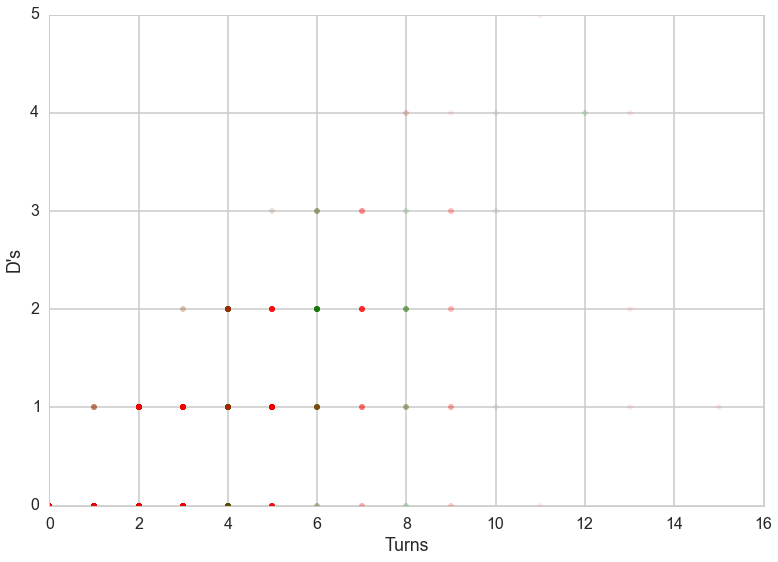

In [57]:
mask_hold = points.apply( lambda x :(x.offense == True and x.won == True), axis=1)
mask_break = points.apply( lambda x :(x.offense == True and x.won == False), axis=1)
plt.plot(points[mask_hold].turns, points[mask_hold].ds, '.', alpha=0.08, c='g')
plt.plot(points[mask_break].turns, points[mask_break].ds, '.', alpha=0.08, c='r')

plt.xlabel("Turns")
plt.ylabel("D's")


In [58]:
from scipy import linalg

def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, color=color, lw=3, fill=False)
    ell.set_clip_box(splot.bbox)
    ell1 = mpl.patches.Ellipse(mean, 1 * v[0] ** 0.5, 1 * v[1] ** 0.5,
                              180 + angle, color=color, lw=3, fill=False)
    ell1.set_clip_box(splot.bbox)
    ell3 = mpl.patches.Ellipse(mean, 3 * v[0] ** 0.5, 3 * v[1] ** 0.5,
                              180 + angle, color=color, lw=3, fill=False)
    ell3.set_clip_box(splot.bbox)
    #ell.set_alpha(0.2)
    splot.add_artist(ell)
    splot.add_artist(ell1)
    splot.add_artist(ell3)


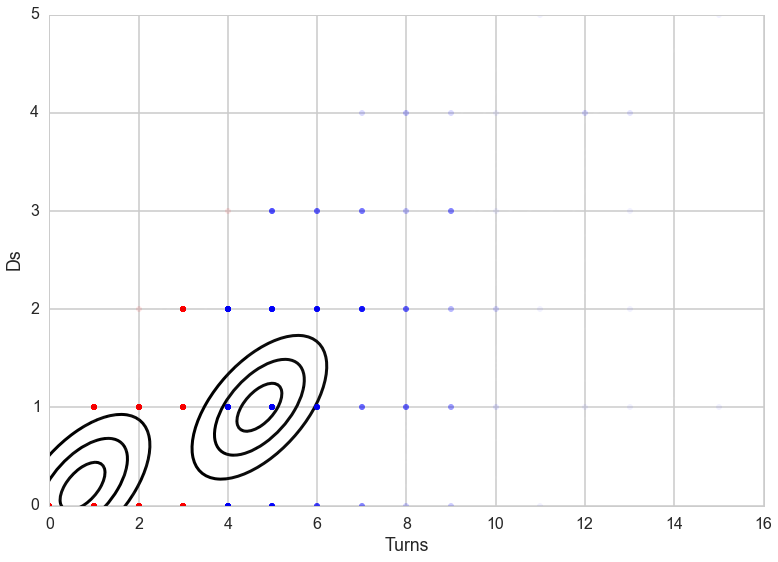

In [69]:
plt.figure()
ax=plt.gca()
plot_ellipse(ax, gmm_means[0], gmm_covar, 'k')
plot_ellipse(ax, gmm_means[1], gmm_covar, 'k')
gmm_labels=clfgmm.predict(Xall)

for k, col in zip(range(n_clusters), ['blue','red']):
    my_members = gmm_labels == k
    ax.plot(Xall[my_members, 0], Xall[my_members, 1], 'w',
            markerfacecolor=col, marker='.', alpha=0.05)
plt.xlabel("Turns")
plt.ylabel("Ds")

## Analysis

This clustering therefore does not demarkate breaks, but instead indicates good and bad points.  However, the problem that is not solved is determine of those that are clustered in red, which ones are exciting points, and which of those are actually turn-filled points because of sloppy play or bad weather.

In [60]:
# try using k means
cluster_cols = points[["turns", "ds", "point_time"]]
model = KMeans(n_clusters=3).fit(cluster_cols.values)
points["cluster"] = model.labels_
points.groupby("cluster").count()

,date,ds,num_throws,offense,point_time,pull-ob,team,turns,won
cluster,,,,,,,,,
0,4219,4219,4219,4219,4219,4219,4214,4219,4219
1,12427,12427,12427,12427,12427,12427,12317,12427,12427
2,1161,1161,1161,1161,1161,1161,1159,1161,1161


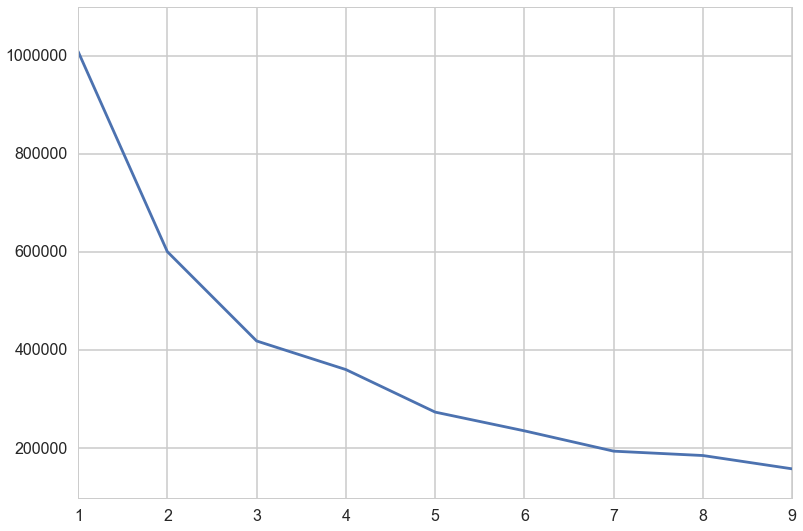

In [61]:
num_clusters = range(1, 10)
models = [KMeans(n_clusters = x) for x in num_clusters]
def score_from_model(model):
    predicted = model.fit_predict(cluster_cols.values)
    centroids = [model.cluster_centers_[x] for x in predicted]
    dist_sum = 0
    for i in range(0, len(predicted)):
        dist_sum += euclidean(cluster_cols.values[i], centroids[i])
    return dist_sum
scores = [score_from_model(model) for model in models]
scores

plt.plot(num_clusters, scores)

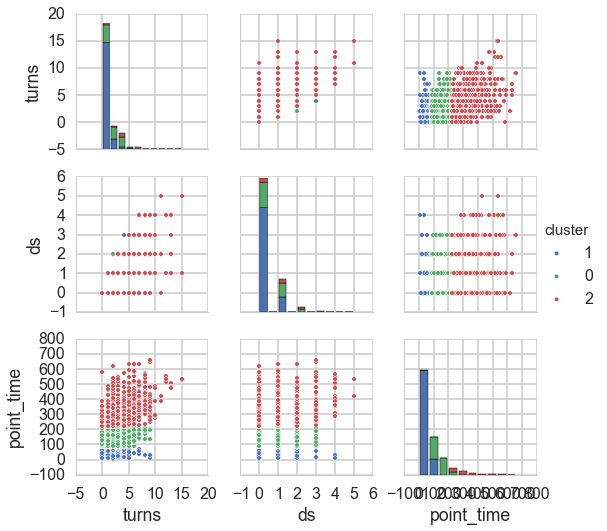

In [62]:
sns.pairplot(points, vars=["turns", "ds", "point_time"], hue="cluster")

Let's try with two clusters as well, as it seels like there is a form of elbow there.

In [63]:
# try using k means
cluster_cols = points[["turns", "ds", "point_time"]]
model = KMeans(n_clusters=2).fit(cluster_cols.values)
points["cluster"] = model.labels_
points.groupby("cluster").count()

,date,ds,num_throws,offense,point_time,pull-ob,team,turns,won
cluster,,,,,,,,,
0,14656,14656,14656,14656,14656,14656,14546,14656,14656
1,3151,3151,3151,3151,3151,3151,3144,3151,3151


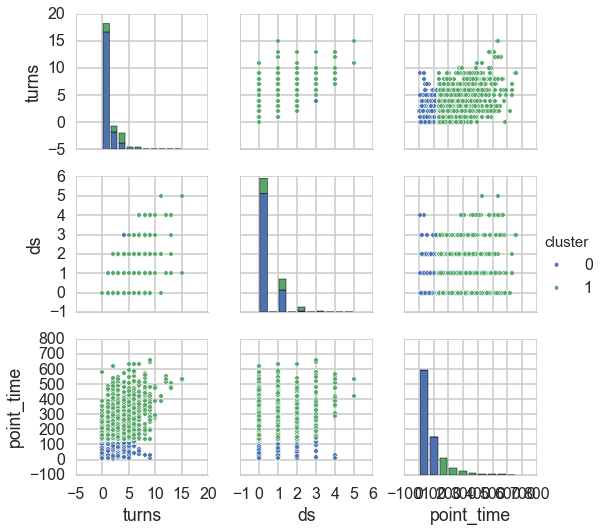

In [64]:
sns.pairplot(points, vars=["turns", "ds", "point_time"], hue="cluster")

Let us try with different parameters

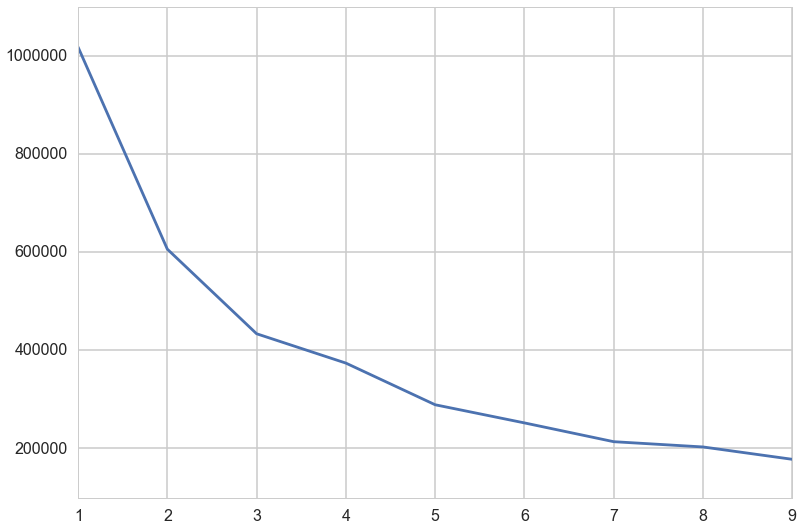

In [65]:
# try using k means
cluster_cols = points[["turns", "ds", "point_time", "num_throws"]]
model = KMeans(n_clusters=3).fit(cluster_cols.values)
points["cluster"] = model.labels_
points.groupby("cluster").count()

num_clusters = range(1, 10)
models = [KMeans(n_clusters = x) for x in num_clusters]
def score_from_model(model):
    predicted = model.fit_predict(cluster_cols.values)
    centroids = [model.cluster_centers_[x] for x in predicted]
    dist_sum = 0
    for i in range(0, len(predicted)):
        dist_sum += euclidean(cluster_cols.values[i], centroids[i])
    return dist_sum
scores = [score_from_model(model) for model in models]
scores

plt.plot(num_clusters, scores)

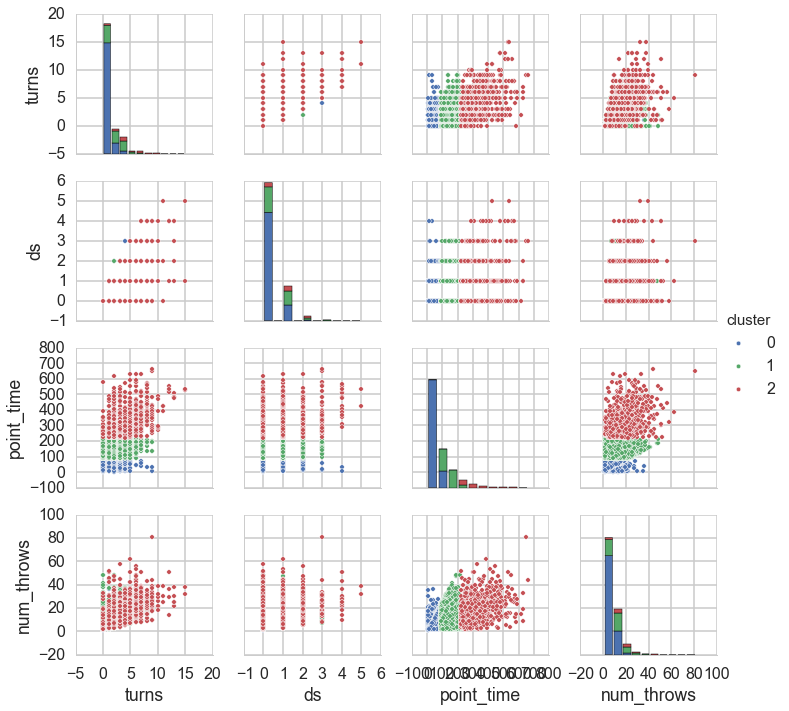

In [66]:
sns.pairplot(points, vars=["turns", "ds", "point_time", "num_throws"], hue="cluster")

## Game Play Analysis

It can be hard to determine what exactly these clusters mean, so we will look at a game to get a sense of what these clusters may mean.  

In [70]:
# summary statistics now with labels
points.groupby("cluster").mean()

,ds,num_throws,offense,point_time,pull-ob,turns,won
cluster,,,,,,,
0,0.136684,5.408451,0.495439,39.385563,0.027449,0.516805,0.451985
1,0.455417,11.103787,0.509827,137.596177,0.034036,1.937440,0.479147
2,0.939421,17.658472,0.513608,306.777875,0.042142,3.960492,0.442493


Examning this reveals that there ds are much less frequent than turns.  And that the number of throws and length of point are the most clear distinguishing feature between the points.  It looks like cluster 1 are the points that are most likly to be exciting.  Around half of those points feature some form of ds, and often few turns.  This means that the points are likely to be more exciting, and they are of a length that indicates that the point was at the very least a hard fought battle.

In [71]:
# defining clusters in plaintext
points.cluster[points.cluster == 2] = "battles"
points.cluster[points.cluster == 0] = "quick_points"
points.cluster[points.cluster == 1] = "clean_points"

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


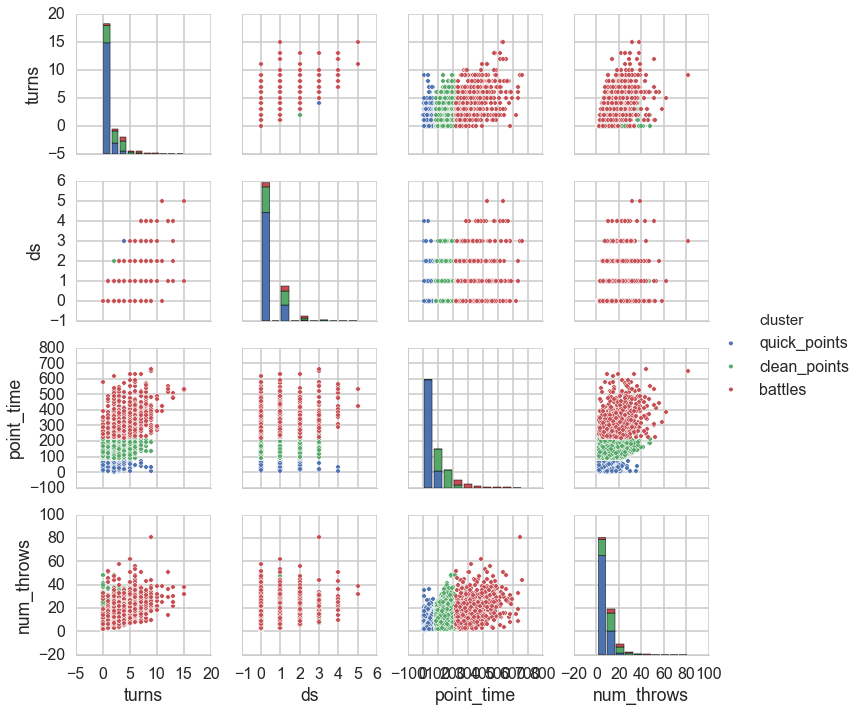

In [72]:
sns.pairplot(points, vars=["turns", "ds", "point_time", "num_throws"], hue="cluster")

In [91]:
set(points["team"])
cascades = points[points.team == "SeattleCascades"]
riptide = points[points.team == 'VancouverRiptide']
cascades_gp = cascades[cascades.date == "2015-04-18 19:34"]
riptide_gp = riptide[riptide.date == "2015-04-18 19:34"]

In [94]:
riptide_gp.head(41)

,date,ds,num_throws,offense,point_time,pull-ob,team,turns,won,cluster
17763,2015-04-18 19:34,0,13,True,113,False,VancouverRiptide,2,False,clean_points
17764,2015-04-18 19:34,0,10,True,54,False,VancouverRiptide,0,True,quick_points
17765,2015-04-18 19:34,0,2,False,10,False,VancouverRiptide,0,False,quick_points
17766,2015-04-18 19:34,0,8,True,43,False,VancouverRiptide,0,True,quick_points
17767,2015-04-18 19:34,1,5,False,64,False,VancouverRiptide,2,False,quick_points
17768,2015-04-18 19:34,0,5,True,170,False,VancouverRiptide,1,False,clean_points
17769,2015-04-18 19:34,0,9,True,47,False,VancouverRiptide,0,True,quick_points
17770,2015-04-18 19:34,0,2,False,43,False,VancouverRiptide,0,False,quick_points
17771,2015-04-18 19:34,1,11,True,102,False,VancouverRiptide,2,True,clean_points
17772,2015-04-18 19:34,0,2,False,48,False,VancouverRiptide,0,False,quick_points


In [95]:
cascades_gp.head(41)

,date,ds,num_throws,offense,point_time,pull-ob,team,turns,won,cluster
15812,2015-04-18 19:34,1,11,False,113,False,SeattleCascades,5,True,clean_points
15813,2015-04-18 19:34,0,2,False,45,False,SeattleCascades,0,False,quick_points
15814,2015-04-18 19:34,0,1,True,7,False,SeattleCascades,0,True,quick_points
15815,2015-04-18 19:34,0,2,False,33,False,SeattleCascades,0,False,quick_points
15816,2015-04-18 19:34,1,10,True,66,False,SeattleCascades,2,True,quick_points
15817,2015-04-18 19:34,0,2,False,22,False,SeattleCascades,0,False,quick_points
15818,2015-04-18 19:34,0,9,True,50,False,SeattleCascades,0,True,quick_points
15819,2015-04-18 19:34,0,2,False,36,False,SeattleCascades,0,False,quick_points
15820,2015-04-18 19:34,0,12,True,55,False,SeattleCascades,0,True,quick_points
15821,2015-04-18 19:34,1,7,False,93,False,SeattleCascades,2,False,clean_points
